In [46]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent

def caluclate_cpm_from_bootstrapping(file_path):
    metrics = pd.read_csv(file_path)

    fps = metrics['FPrate']
    mean_sens = metrics['Sensivity[Mean]']
    low_mean_sens = metrics['Sensivity[Lower bound]']
    high_mean_sens = metrics['Sensivity[Upper bound]']

    idxs = []
    for fps_value in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        idxs.append(np.abs(fps - fps_value).argmin())
        
    fps = fps[idxs]
    mean_sens = mean_sens[idxs]
    low_sens = low_mean_sens[idxs]
    high_sens = high_mean_sens[idxs]

    
    df = pd.DataFrame({'fps': fps, 'mean_sens': mean_sens, 'low_sens': low_sens, 'high_sens': high_sens}).apply(lambda x: np.round(x,2))
    mean_cpm = df['mean_sens'].mean()
    low_cpm = df['low_sens'].mean()
    high_cpm = df['high_sens'].mean()

    display(df)
    print('Mean Sensitivity:', np.round(mean_cpm,2), 'Low Sensitivity:', np.round(low_cpm,2), 'High Sensitivity:', np.round(high_cpm,2))

def show_metrics(file_path):
    metrics = pd.read_csv(file_path, skiprows=6, sep=':').rename(columns={0:'Metric',1:'Value'}).round(3)
    display(metrics)

# GRT123 - Trained & Eval SUMMIT

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.13,0.18
159,0.25,0.22,0.19,0.25
476,0.50,0.31,0.28,0.34
1111,1.00,0.41,0.37,0.45
2381,2.00,0.54,0.50,0.58
4920,4.00,0.70,0.67,0.74
9999,8.00,0.83,0.80,0.85


Mean Sensitivity: 0.45 Low Sensitivity: 0.42 High Sensitivity: 0.48


,True positives,995
0,False positives,26867.000
1,False negatives,121.000
2,True negatives,0.000
3,Total number of candidates,27884.000
4,Total number of nodules,1116.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,24.000
7,Sensitivity,0.892
8,Average number of candidates per scan,31.260


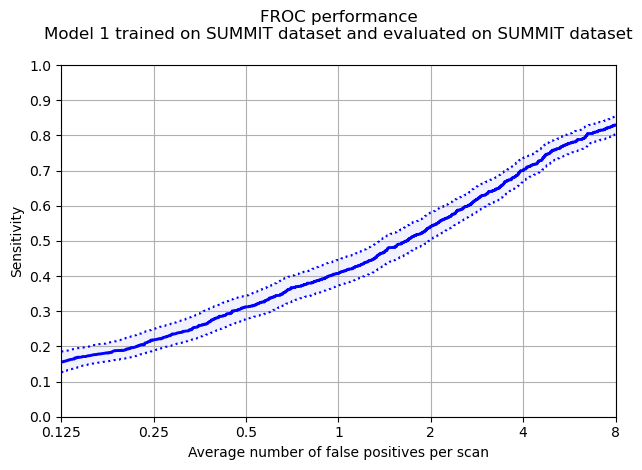

In [47]:
grt123_summit_summit = noduleCADEvaluation(
    annotations_filename='/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv',
    annotations_excluded_filename='/Users/john/Projects/SOTAEvaluationNoduleDetection/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename='/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/partial/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv",    
    filter='\nModel 1 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/partial',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/partial/froc_partial_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/partial/CADAnalysis.txt')

## Gender Analysis 

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp92_o_llx/annotations.csv
Total number of included nodule annotations: 456
Total number of nodule annotations: 456
Cases: 362


100%|██████████| 1000/1000 [00:10<00:00, 98.01it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp3sxymjti/annotations.csv
Total number of included nodule annotations: 660
Total number of nodule annotations: 660
Cases: 531
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:24<00:00, 41.12it/s]


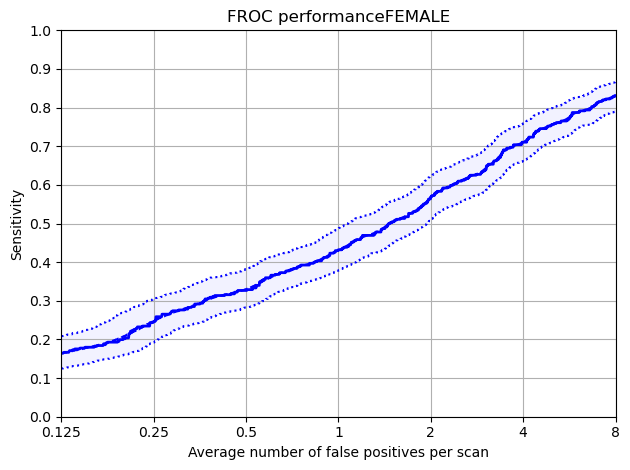

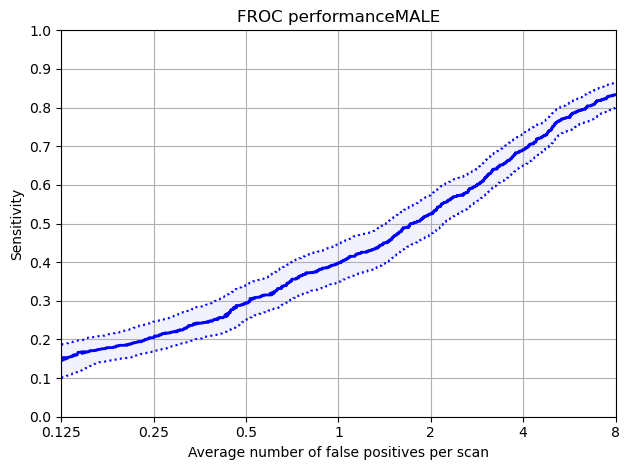

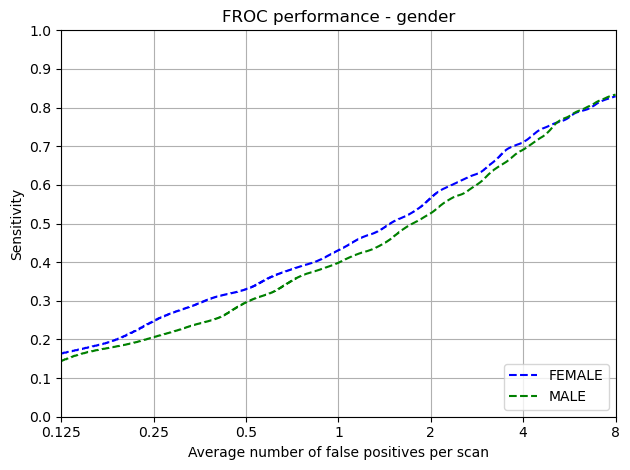

In [48]:
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter

def protected_group_analysis(protected_group, scan_metadata, annotations, exclusions, predictions, output_path):

    output_path = Path(output_path)

    analysis_dict = {}

    for cat in scan_metadata[protected_group].unique():
        with TemporaryDirectory() as temp_dir:
            temp_dir = Path(temp_dir)
            temp_scans = scan_metadata[scan_metadata[protected_group] == cat]['name']
            temp_annotations = annotations[annotations['name'].isin(temp_scans.values)]
            temp_exclusions = exclusions[exclusions['name'].isin(temp_scans.values)]
            temp_predictions = predictions[predictions['name'].isin(temp_scans.values)]

            temp_scans.to_csv(temp_dir / 'scans.csv', index=False)
            temp_annotations.to_csv(temp_dir / 'annotations.csv', index=False)
            temp_exclusions.to_csv(temp_dir / 'exclusions.csv', index=False)
            temp_predictions.to_csv(temp_dir / 'predictions.csv', index=False)

            result = noduleCADEvaluation(
                annotations_filename=temp_dir / 'annotations.csv',
                annotations_excluded_filename=temp_dir / 'exclusions.csv',
                seriesuids_filename=temp_dir / 'scans.csv',
                results_filename=temp_dir / 'predictions.csv',
                filter=f'-{cat}',
                outputDir=output_path / cat,
            )

            caluclate_cpm_from_bootstrapping(output_path / cat / 'froc_predictions_bootstrapping.csv')
            show_metrics(output_path / cat / 'CADAnalysis.txt')

            analysis_dict[cat] = (
                pd.read_csv(output_path / cat / 'froc_predictions_bootstrapping.csv')
                .rename(columns={
                    'FPrate': 'FPRate',
                    'Sensivity[Mean]': 'Sensitivity',
                    'Sensivity[Lower bound]': 'LowSensitivity',
                    'Sensivity[Upper bound]': 'HighSensitivity'
                })
            )

    fig1 = plt.figure()
    ax = plt.gca()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for idx, cat in enumerate(analysis_dict.keys()):

        metrics = analysis_dict[cat]        
        plt.plot(metrics['FPRate'], metrics['Sensitivity'], ls='--', color=colors[idx],label=cat)
        # plt.plot(metrics['FPRate'], metrics['LowSensitivity'], ls=':', color=colors[idx])
        # plt.plot(metrics['FPRate'], metrics['HighSensitivity'], ls=':', color=colors[idx])
        # ax.fill_between(metrics['FPRate'], metrics['LowSensitivity'], metrics['HighSensitivity'], alpha=0.05)

    xmin = 0.125
    xmax = 8
    plt.xlim(xmin, xmax)
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    #plt.legend(loc='lower right')
    plt.title(f'FROC performance - {protected_group}')
    plt.xscale('log', base=2)
    ax.xaxis.set_major_formatter(FixedFormatter([0.125,0.25,0.5,1,2,4,8]))

    # set your ticks manually
    ax.xaxis.set_ticks([0.125,0.25,0.5,1,2,4,8])
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    plt.legend(loc='lower right')
    plt.grid(visible=True, which='both')
    plt.tight_layout()

scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
)

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

## Ethnicity Analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpotrm8ky1/annotations.csv
Total number of included nodule annotations: 18
Total number of nodule annotations: 18
Cases: 21


100%|██████████| 1000/1000 [00:01<00:00, 984.52it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpe2qvlvhs/annotations.csv
Total number of included nodule annotations: 852
Total number of nodule annotations: 852
Cases: 660
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:31<00:00, 31.97it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpo7k4lzda/annotations.csv
Total number of included nodule annotations: 71
Total number of nodule annotations: 71
Cases: 66


100%|██████████| 1000/1000 [00:02<00:00, 449.49it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp8y6_60zg/annotations.csv
Total number of included nodule annotations: 147
Total number of nodule annotations: 147
Cases: 117


100%|██████████| 1000/1000 [00:03<00:00, 300.42it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp42x3be3p/annotations.csv
Total number of included nodule annotations: 28
Total number of nodule annotations: 28
Cases: 32


100%|██████████| 1000/1000 [00:01<00:00, 796.31it/s]


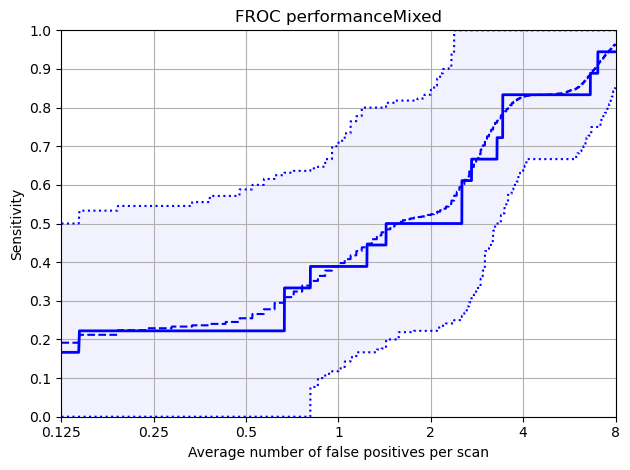

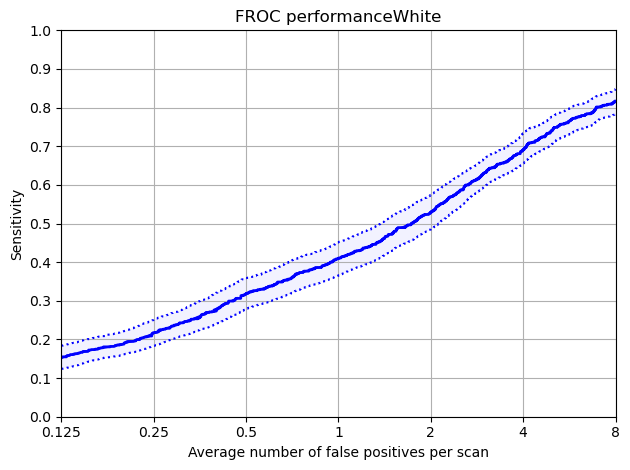

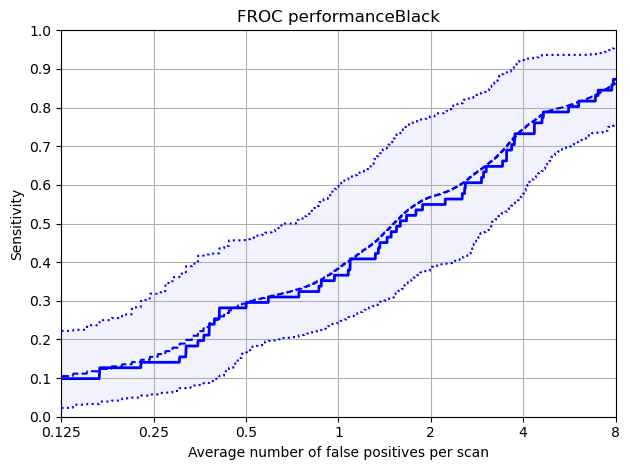

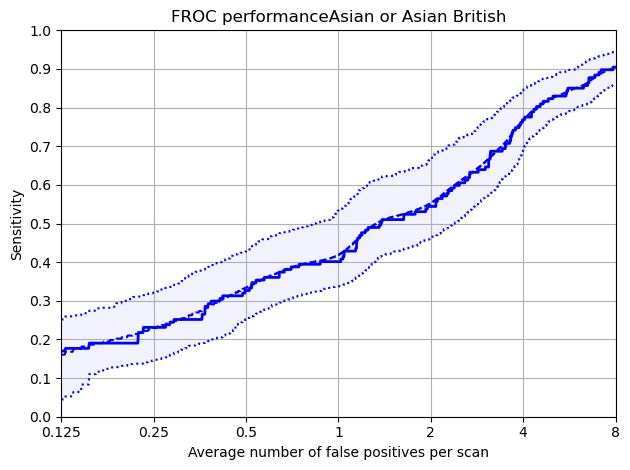

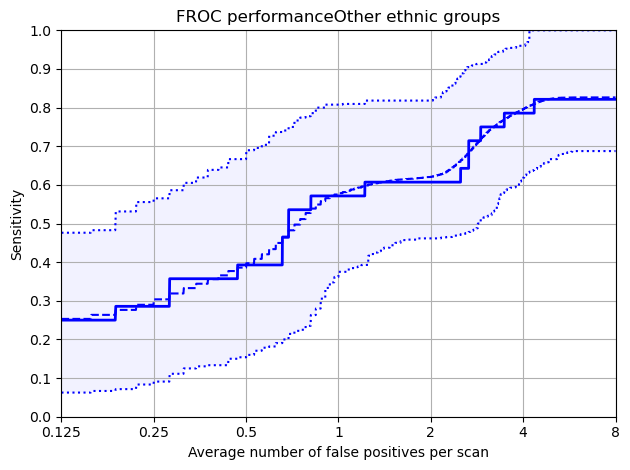

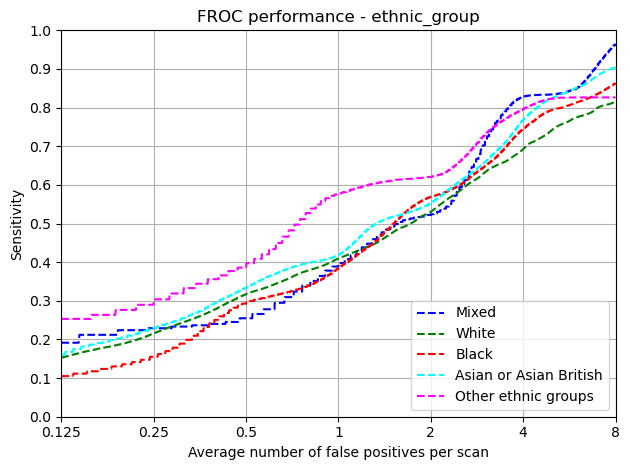

In [49]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

# MONAI Detection - Trained & Eval on SUMMIT

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/partial.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/annotations.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! 

100%|██████████| 1000/1000 [01:01<00:00, 16.23it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.13,0.19
159,0.25,0.25,0.21,0.30
476,0.50,0.38,0.34,0.42
1111,1.00,0.54,0.49,0.58
2381,2.00,0.67,0.63,0.72
4920,4.00,0.76,0.71,0.80
9999,8.00,0.81,0.76,0.85


Mean Sensitivity: 0.51 Low Sensitivity: 0.47 High Sensitivity: 0.55


,True positives,944
0,False positives,44062.000
1,False negatives,172.000
2,True negatives,0.000
3,Total number of candidates,45995.000
4,Total number of nodules,1116.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,999.000
7,Sensitivity,0.846
8,Average number of candidates per scan,51.564


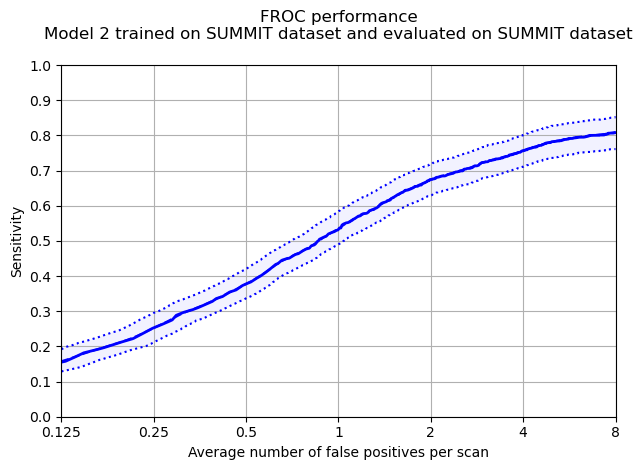

In [53]:
from json import detect_encoding


def combine_predictions(predictions_json_path, dataset_name, use_nms=True):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_json_path = Path(predictions_json_path)

    predictions_list = []

    for prediction_json_path in predictions_json_path.glob('*json'):
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image_cnt, image in enumerate(predictions_json[dataset_name]):
            name = image['image'].split('/')[-1][:-7]
            
            image_predictions_dict = {}
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                image_predictions_dict[idx] = prediction
                idx+=1
            
            image_predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')
            predictions_list.append(image_predictions)

    predictions = pd.concat(predictions_list, ignore_index=True)
    predictions.to_csv(predictions_json_path / 'predictions.csv', index=False)

    return predictions_json_path / 'predictions.csv'

predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit', 'test')
predictions = pd.read_csv(predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    results_filename=predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/partial',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/partial/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/partial/CADAnalysis.txt')



## Gender analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmph0tmre33/annotations.csv
Total number of included nodule annotations: 456
Total number of nodule annotations: 456
Cases: 362


100%|██████████| 1000/1000 [00:18<00:00, 54.49it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp2jhitbsc/annotations.csv
Total number of included nodule annotations: 660
Total number of nodule annotations: 660
Cases: 531
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark No

100%|██████████| 1000/1000 [00:30<00:00, 32.53it/s]


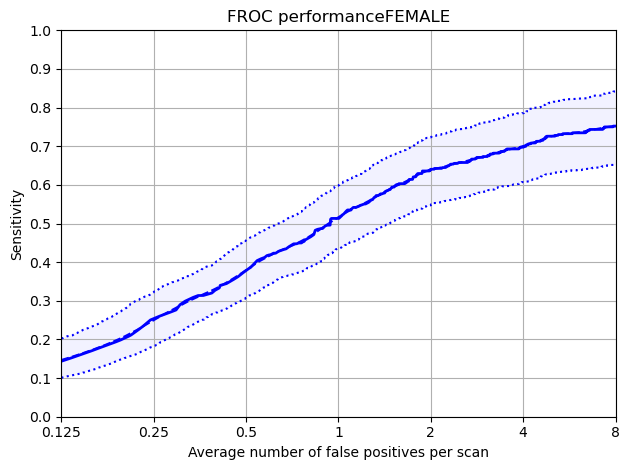

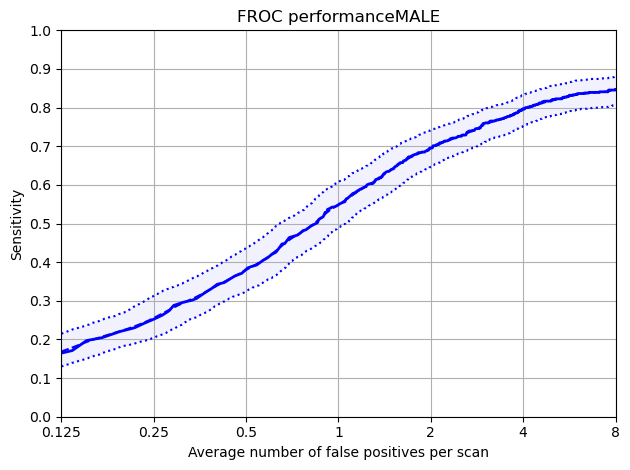

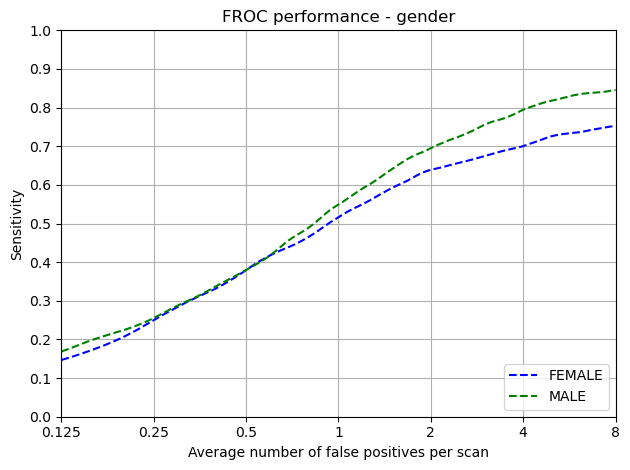

In [54]:
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/annotations.csv')

predictions = pd.read_csv(predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

## Ethnicity Analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp6tkb4ogo/annotations.csv
Total number of included nodule annotations: 18
Total number of nodule annotations: 18
Cases: 21


100%|██████████| 1000/1000 [00:01<00:00, 751.32it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpaywmzroo/annotations.csv
Total number of included nodule annotations: 852
Total number of nodule annotations: 852
Cases: 660
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark No

100%|██████████| 1000/1000 [00:42<00:00, 23.42it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpev9202e9/annotations.csv
Total number of included nodule annotations: 71
Total number of nodule annotations: 71
Cases: 66


100%|██████████| 1000/1000 [00:02<00:00, 375.50it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp54cq8u1g/annotations.csv
Total number of included nodule annotations: 147
Total number of nodule annotations: 147
Cases: 117


100%|██████████| 1000/1000 [00:05<00:00, 187.18it/s]


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpl28l27ho/annotations.csv
Total number of included nodule annotations: 28
Total number of nodule annotations: 28
Cases: 32


100%|██████████| 1000/1000 [00:01<00:00, 597.76it/s]


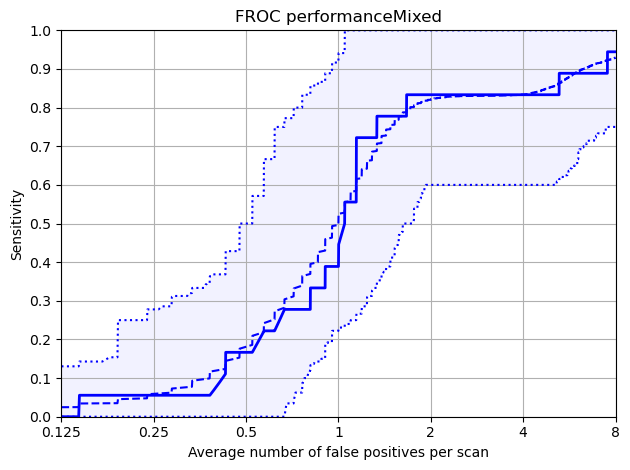

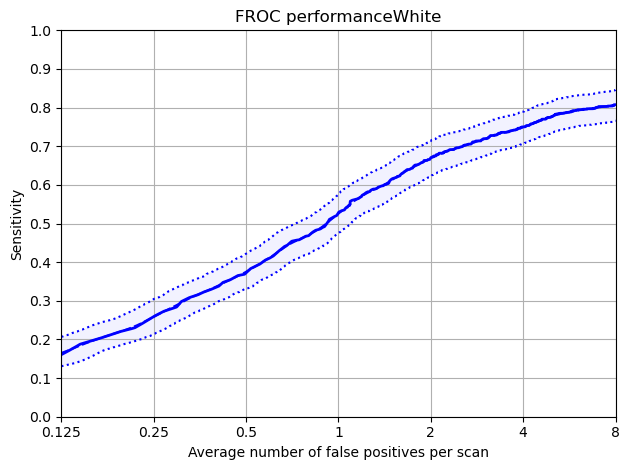

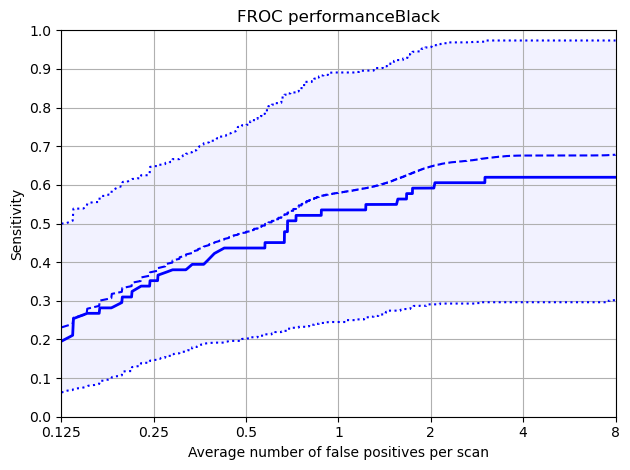

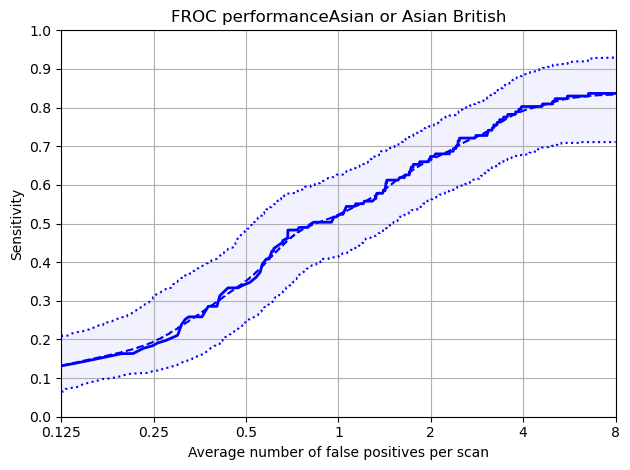

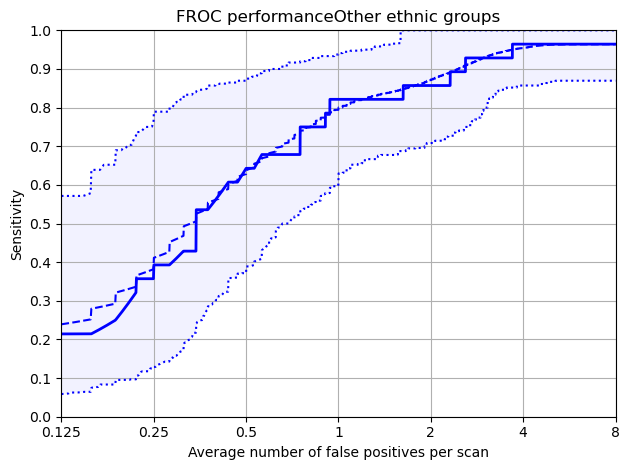

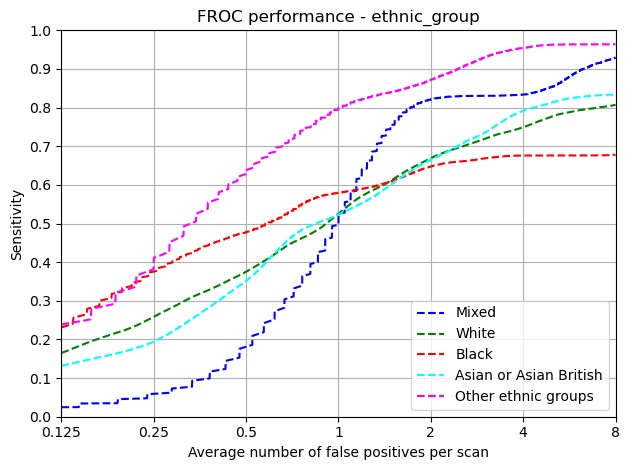

In [55]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)